**Project Goal: How can we predict and manage default risk in microfinance?**

Most important Hypothesis(for me) in this project is:

1. Hypothesis 03. The more client has ability to pay off(istead of making default micro finance), they will choose 5 weeks credit ease product.
-> 10 weeks credit ease clients make highest miss-instalments rate, 7 weeks credit ease clients make highest default rate.
-> 7, 10 weeks credit ease clients borrow more amount of money, less payback on time so it's risk for company.
## how about set up feature transpormation [ Weight of Evidence (WoE) Encoding ] ?

2. Hypothesis 05. Risk of default micro finance is different by branch as their lifestlye, quality of life, average salary might be different.
-> Engineer branch has higher rate to make defaulty. Depends on geographic, feature of city, risk of default rate can be impacted.
## By using [ Branch × BusinessType Target Encoding ] we could predict high risk client ?

3. Hypothesis 06. Frequent client has high risk to make default micro finance.
-> Client those who use product 3-4 times has highest risk to make defaulty while 1-2, 5-6 times clients have lower risk.
## How about set up [ Loan Cycle Binning ] so that AI can give high risk point according to cycle ?



# Feature engineering
1. Feature Selection 
2. Encoding Categorical data
3. Handling Missing values
4. Feature Transformation
5. Balancing datasets

<class 'pandas.core.frame.DataFrame'>
Index: 1565 entries, 0 to 3469
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   LoanId                        1565 non-null   int64         
 1   AmountDisbursed               1565 non-null   int64         
 2   Interest                      1565 non-null   int64         
 3   LoanBalance                   1565 non-null   float64       
 4   BorrowDate                    1565 non-null   datetime64[ns]
 5   Product                       1565 non-null   object        
 6   Branch                        1565 non-null   object        
 7   ClearDate                     1565 non-null   datetime64[ns]
 8   CustomerId                    1565 non-null   int64         
 9   Gender                        1565 non-null   object        
 10  LoanLimit                     1565 non-null   float64       
 11  CreditScore                   1565 

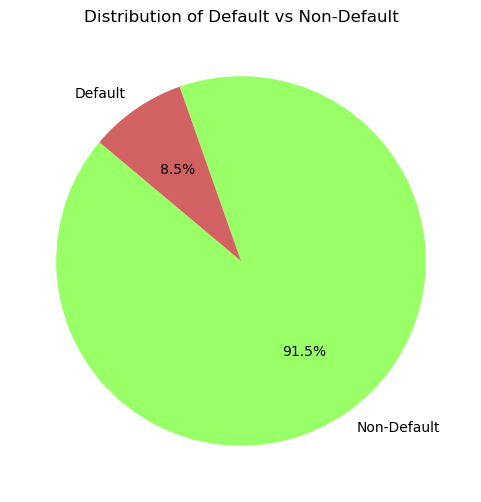

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt 
import seaborn as sns

pd.set_option("display.max_columns", 100)

# Load the main dataset 
df = pd.read_csv('cleaned_dataset.csv')

# Display the first few rows of the dataset 
df.head()

# BorrowDate:  MM/DD/YYYY (Keep dayfirst=False)
df["BorrowDate"] = pd.to_datetime(df["BorrowDate"], errors="coerce", dayfirst=False)

# problematic columns: Use format='mixed' to handle the mix of DD/MM/YYYY and YYYY-MM-DD
df["loan_repayment_first_payment"] = pd.to_datetime(df["loan_repayment_first_payment"], errors="coerce", dayfirst=True, format='mixed')
df["loan_repayment_last_payment"] = pd.to_datetime(df["loan_repayment_last_payment"], errors="coerce", dayfirst=True, format='mixed')

# ClearDate:  YYYY-MM-DD
df["ClearDate"] = pd.to_datetime(df["ClearDate"], errors="coerce", format="%Y-%m-%d")

# More data cleaning 
# A customer cannot make a repayment 100 days BEFORE they borrowed the money.
# We allow a small buffer (-10 days) for potential booking errors, but anything less is garbage.
df['days_to_first'] = (df['loan_repayment_first_payment'] - df['BorrowDate']).dt.days
df = df[(df['days_to_first'] >= -10) | (df['days_to_first'].isna())].copy()

# The data logs the same loan twice. We keep only the first instance.
df = df.drop_duplicates(subset=['CustomerId', 'BorrowDate'], keep='first')

# A loan cannot be cleared BEFORE it was borrowed.
df = df[df['ClearDate'] >= df['BorrowDate']].copy()

# A business established in 2024 cannot borrow money in 2023.
df = df[df['YearEstablished'] <= df['BorrowDate'].dt.year].copy()

# Cleanup to remove Product types (sme - 3 months, sme - 4 months and 12 weeks credit ease) fron the dataset
df = df[~df['Product'].isin(['sme - 3 months', 'sme - 4 months', '12 weeks credit ease'])]
df.info()

df.shape

# Understading the target variable Default where default is when ClearDate is greater than 2025-12-15 and LoanBalance is greater than 0
defaulters = ((df['ClearDate'] < '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)
print("Number of defaulters:", defaulters.sum())

# Calculate the percentage of defaults vs non-defaults
default_counts = defaulters.value_counts(normalize=True) * 100
print("Percentage of Defaults vs Non-Defaults:\n", default_counts)

# Visualize the distribution of the target variable as a pie chart
plt.figure(figsize=(6, 6))
plt.pie(default_counts, labels=['Non-Default', 'Default'], autopct='%1.1f%%', startangle=140, colors=["#99ff66","#d26161"])
plt.title('Distribution of Default vs Non-Default')
plt.show()

**Feature Selection**
Our dataset is already clean, so only drop Identifiers (LoanId, CustomerId)

1. Remove Unique Identifiers: Drop LoanId and CustomerId - no predictive power in actual ML

In [2]:
# Code to remove LoanId and CustomerId from the datasets
columns_to_drop = ['LoanId', 'CustomerId']
df = df.drop(columns=columns_to_drop)

# Display the first few rows of the dataset 
df.head()

,AmountDisbursed,Interest,LoanBalance,BorrowDate,Product,Branch,ClearDate,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished
0,6000,1750,7750.0,2025-11-29,5 weeks credit ease,engineer,2026-03-01,female,8000.0,3500,1,500,2025-11-29,2025-11-29,0,5.0,food & hospitality,green grocery (fruit/vegetables),2017
1,4000,1250,5250.0,2025-11-28,5 weeks credit ease,molo,2026-02-01,female,9600.0,2500,1,1550,2025-11-28,2025-11-28,0,4.0,food & hospitality,retail shop,2019
2,4000,1250,5250.0,2025-11-26,5 weeks credit ease,engineer,2025-12-31,female,8000.0,3500,1,1350,2025-11-26,2025-11-26,0,4.0,food & hospitality,green grocery (fruit/vegetables),2014
3,4000,1250,5250.0,2025-11-25,5 weeks credit ease,molo,2025-12-30,female,10000.0,1500,1,1000,2025-11-25,2025-11-25,0,4.0,food & hospitality,green grocery (fruit/vegetables),2018
4,4000,1250,5250.0,2025-11-24,5 weeks credit ease,molo,2025-12-29,female,10000.0,1500,1,1550,2025-11-24,2025-11-24,0,4.0,business & information,bureau & publishing services,2018


**Encoding Categorical data**

1. Gender & Branch: Use Binary Encoding (0 or 1) - as they only have two categories.

2. Product type :  Use One-Hot Encoding. Since there are only 3 products, this won't create too many columns.

3. Industry & BusinessType: Use Frequency Encoding - replacing the name with its percentage in the dataset.

In [3]:
#1. Gender & Branch: Use Binary Encoding (0 or 1) - as they only have two categories.
## Binary Encoding for Gener / Branch
df['Gender'] = df['Gender'].map({'male': 1, 'female': 0})
df['Branch'] = df['Branch'].map({'engineer': 1, 'molo': 0})

#2. Product type :  Use One-Hot Encoding. Since there are only 3 products, this won't create too many columns.
## prefix='Product' adds a label to the new columns for better organization
product_dummies = pd.get_dummies(df['Product'], prefix='Product')
df = pd.concat([df, product_dummies], axis=1) # Join the new columns back to the main dataframe
df = df.drop(columns=['Product']) # Drop the original 'Product' column (since it's now encoded)

#3. Industry & BusinessType: Use Frequency Encoding - replacing the name with its percentage in the dataset.
## This replaces the name with the percentage (0.0 to 1.0) of its occurrence
industry_freq = df['Industry'].value_counts(normalize=True)
df['Industry'] = df['Industry'].map(industry_freq)

## Frequency Encoding for BusinessType
business_type_freq = df['BusinessType'].value_counts(normalize=True)
df['BusinessType'] = df['BusinessType'].map(business_type_freq)

# Display the first few rows of the dataset 
df.head()

,AmountDisbursed,Interest,LoanBalance,BorrowDate,Branch,ClearDate,Gender,LoanLimit,CreditScore,loan_repayment_txn_count,loan_repayment_total_paid,loan_repayment_first_payment,loan_repayment_last_payment,loan_overpayment,MissedInstalments,Industry,BusinessType,YearEstablished,Product_10 weeks credit ease,Product_12 weeks credit ease,Product_5 weeks credit ease,Product_7 weeks credit ease,Product_sme - 3 months,Product_sme - 4 months
0,6000,1750,7750.0,2025-11-29,1,2026-03-01,0,8000.0,3500,1,500,2025-11-29,2025-11-29,0,5.0,0.595622,0.312500,2017,False,False,True,False,False,False
1,4000,1250,5250.0,2025-11-28,0,2026-02-01,0,9600.0,2500,1,1550,2025-11-28,2025-11-28,0,4.0,0.595622,0.094470,2019,False,False,True,False,False,False
2,4000,1250,5250.0,2025-11-26,1,2025-12-31,0,8000.0,3500,1,1350,2025-11-26,2025-11-26,0,4.0,0.595622,0.312500,2014,False,False,True,False,False,False
3,4000,1250,5250.0,2025-11-25,0,2025-12-30,0,10000.0,1500,1,1000,2025-11-25,2025-11-25,0,4.0,0.595622,0.312500,2018,False,False,True,False,False,False
4,4000,1250,5250.0,2025-11-24,0,2025-12-29,0,10000.0,1500,1,1550,2025-11-24,2025-11-24,0,4.0,0.004032,0.001728,2018,False,False,True,False,False,False


**Feature Transformation**

1. Log Transformation for AmountDisbursed, CreditScore, Loanlimit as those are highly skewed

2. Loan Cycle Binning - According to EDA (Loan Frequency, clients who are in cycle 3-4 have high risk to make feault, while others have lower risk to make defaulty)

3. Scaling (Standardization) - To ensure that a large number like LoanLimit (e.g., 10,000) doesn't overpower a small number like BusinessAge (e.g., 5), we scale all numerical inputs.

In [13]:
# Hypothesis 03. Product & Credit Interaction (Risk Exposure Index)

# Extract the numeric part from the 'Product' column to get loan duration in weeks
df['Prod_Weeks'] = df['Product'].str.extract('(\d+)').astype(float)
# Create the new feature 'Risk_Exposure_Index'
df['Risk_Exposure_Index'] = df['Prod_Weeks'] / (df['CreditScore'] + 1)

In [19]:
# Hypothesis 05. Branch & Business Type Interaction (Risk profile by branch and business type)

df['IsDefault'] = ((df['ClearDate'] < '2025-12-15') & (df['LoanBalance'] > 0)).astype(int)

# Create a combined feature for Branch and BusinessType
branch_biz_risk = df.groupby(['Branch', 'BusinessType'])['IsDefault'].transform('mean')
df['Branch_Biz_Risk_Score'] = branch_biz_risk

In [24]:
# Hypothesis 06. Frequent client has high risk to make default micro finance.

# 2. Loan Cycle Binning - According to EDA (Loan Frequency, clients who are in cycle 3-4 have high risk to make feault, while others have lower risk to make defaulty)
# A. Loan Cycle Binning (Your finding: 3-4 is high risk, 5-6 is lower)
def bin_loan_cycle(count):
    if count <= 2: return 'Low_Freq'
    if 3 <= count <= 4: return 'High_Risk_Cycle'
    if 5 <= count <= 6: return 'Stable_Cycle'
    return 'Veteran'

# Assuming 'LoanCount' is your column for number of loans per client
df['Cycle_Group'] = df['loan_repayment_txn_count'].map(bin_loan_cycle) # or appropriate column

# B. Transaction Count Binning (Your finding: 0-4 highest, 50+ increasing)
df['Txn_Group'] = pd.cut(df['loan_repayment_txn_count'], 
                         bins=[-1, 4, 49, 1000], 
                         labels=['Highest_Risk_Txn', 'Mild_Risk_Txn', 'Increased_Risk_Txn'])

# C. Missed Installment Binning (Your finding: 0 is high, 1-5 lower, 6 highest)
def bin_missed(count):
    if count == 0: return 'No_Miss_Unexpected_Risk'
    if 1 <= count <= 5: return 'Typical_Delay'
    return 'Critical_Default'

df['Missed_Group'] = df['MissedInstalments'].map(bin_missed)

In [20]:
# . Loan Utilization & Burden

# Rate of loan utilized against the limit
df['Loan_Utilization'] = df['AmountDisbursed'] / df['LoanLimit']
# Average daily interest burden
df['Daily_Interest_Burden'] = df['Interest'] / df['Prod_Weeks']

In [22]:
# Business Age at the time of the loan
df['BusinessAge'] = df['BorrowDate'].dt.year - df['YearEstablished']

**Heatmap metrix only with new features**

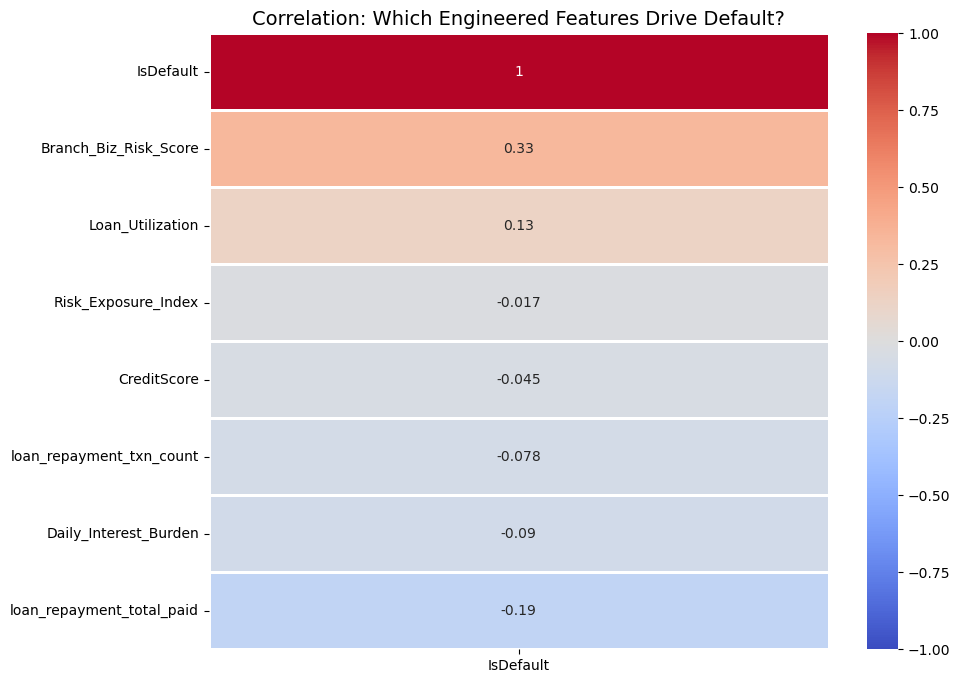

--- Correlation Values with IsDefault ---
IsDefault                    1.000000
Branch_Biz_Risk_Score        0.334426
Loan_Utilization             0.128507
Risk_Exposure_Index         -0.016821
CreditScore                 -0.045032
loan_repayment_txn_count    -0.077714
Daily_Interest_Burden       -0.090203
loan_repayment_total_paid   -0.191607
Name: IsDefault, dtype: float64


In [ ]:
# Final Features for Matrix (only with new features)
features_to_analyze = [
    'IsDefault', 'Risk_Exposure_Index', 'Branch_Biz_Risk_Score', 
    'Loan_Utilization', 'Daily_Interest_Burden', 'CreditScore', 
    'loan_repayment_txn_count', 'loan_repayment_total_paid'
]

corr_matrix = df[features_to_analyze].corr()

# Visualization of Correlation Matrix (Sorted Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['IsDefault']].sort_values(by='IsDefault', ascending=False), 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, vmax=1,
            linewidths=1,
            linecolor='white')

plt.title('Correlation: Which Engineered Features Drive Default?', fontsize=14)
plt.show()

print("--- Correlation Values with IsDefault ---")
print(corr_matrix['IsDefault'].sort_values(ascending=False))

**Heatmap metrix with all the features**

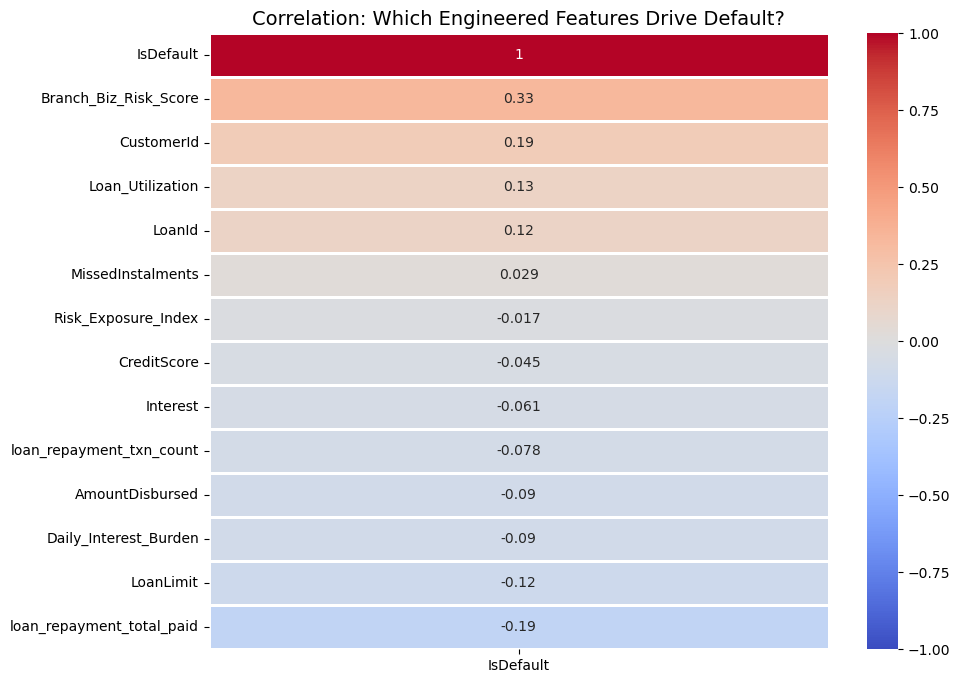

--- Correlation Values with IsDefault ---
IsDefault                    1.000000
Branch_Biz_Risk_Score        0.334426
CustomerId                   0.191591
Loan_Utilization             0.128507
LoanId                       0.124518
MissedInstalments            0.029395
Risk_Exposure_Index         -0.016821
CreditScore                 -0.045032
Interest                    -0.060717
loan_repayment_txn_count    -0.077714
AmountDisbursed             -0.090203
Daily_Interest_Burden       -0.090203
LoanLimit                   -0.115475
loan_repayment_total_paid   -0.191607
Name: IsDefault, dtype: float64


In [ ]:
# Final Features for Matrix (with all the features)
features_to_analyze_all = [
    'LoanId', 'CustomerId','AmountDisbursed', 'Interest', 'LoanLimit', 'CreditScore',
    'loan_repayment_total_paid', 'MissedInstalments', 'IsDefault', 'Risk_Exposure_Index', 'Branch_Biz_Risk_Score', 
    'Loan_Utilization', 'Daily_Interest_Burden','loan_repayment_txn_count'
]

corr_matrix = df[features_to_analyze_all].corr()

# Visualization of Correlation Matrix (Sorted Heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix[['IsDefault']].sort_values(by='IsDefault', ascending=False), 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, vmax=1,
            linewidths=1,
            linecolor='white')

plt.title('Correlation: Which Engineered Features Drive Default?', fontsize=14)
plt.show()

print("--- Correlation Values with IsDefault ---")
print(corr_matrix['IsDefault'].sort_values(ascending=False))

**Balancing datasets -> Using SMOTE to balance the data when we train the AI**

The initial 50/50 split was based on anyone missing an installment. However, our refined business definition of default—unpaid balance past the clear date—shows that only 8.5% of our clients are in actual default. Because this is an imbalanced dataset, we need to use SMOTE or balanced class weights to ensure the model doesn't overlook the minority group.